General strategy:

- Download stocks 
- Reorder to make ticker as the row
- find momentum of each (1mo period)
- find p value: correlation of momentum with returns (close price)
- score: result of spearman correlation
- Daily/Monthly correlation
- Rank based on scores, divide into buckets and calculated average returns per bucket. 
- buy first basket, sell last basket every month


total_return = strategy_returns.sum()
ann_return = 100*((1 + total_return)**(12.0 /float(strategy_returns.index.size))-1)
print('Annual Returns: %.2f%%'%ann_return)


separate dataframe for forward returns by period

Aside from ranking factor, everything is mechanical 

for close price: use Adj Close


In [1]:
#Install prereq packages
!pip install -q yfinance pandas matplotlib numpy #truncate output because annoying

In [2]:
import yfinance as yf
import itertools

#Get company tickers
sectors=["basic-materials","communication-services","consumer-cyclical","consumer-defensive","energy","financial-services",
         "healthcare","industrials","real-estate","technology"]

universe_list=[]
for sector in sectors:
    universe_list.append(list(yf.Sector(sector).top_companies.index[:10]))

ticker_list=list(itertools.chain(*universe_list))
ticker_list

['LIN',
 'SHW',
 'ECL',
 'NEM',
 'SCCO',
 'CRH',
 'APD',
 'FCX',
 'CTVA',
 'VMC',
 'GOOG',
 'META',
 'NFLX',
 'TMUS',
 'DIS',
 'T',
 'VZ',
 'SPOT',
 'APP',
 'CMCSA',
 'AMZN',
 'TSLA',
 'HD',
 'MCD',
 'BKNG',
 'TJX',
 'LOW',
 'MELI',
 'NKE',
 'DASH',
 'WMT',
 'COST',
 'PG',
 'KO',
 'PM',
 'PEP',
 'MO',
 'MDLZ',
 'CL',
 'MNST',
 'XOM',
 'CVX',
 'COP',
 'WMB',
 'EPD',
 'EOG',
 'KMI',
 'ET',
 'MPC',
 'LNG',
 'BRK-B',
 'JPM',
 'V',
 'MA',
 'BAC',
 'GS',
 'WFC',
 'MS',
 'C',
 'AXP',
 'LLY',
 'JNJ',
 'ABBV',
 'UNH',
 'ABT',
 'MRK',
 'TMO',
 'ISRG',
 'AMGN',
 'DHR',
 'GE',
 'RTX',
 'CAT',
 'BA',
 'GEV',
 'HON',
 'ETN',
 'UNP',
 'DE',
 'LMT',
 'WELL',
 'PLD',
 'AMT',
 'EQIX',
 'SPG',
 'DLR',
 'O',
 'PSA',
 'CBRE',
 'CCI',
 'NVDA',
 'MSFT',
 'AAPL',
 'AVGO',
 'ORCL',
 'PLTR',
 'AMD',
 'CSCO',
 'CRM',
 'IBM']

In [3]:
#Download historical data
import pandas as pd
price_data=pd.DataFrame()
for ticker in ticker_list:
    try:
        price_data[ticker]=yf.Ticker(ticker).history(period='5y')['Close']
            
    except Exception as e:
        print(f"Failed to download {ticker}: {e}")
        continue
    
price_data=price_data.T 

In [4]:
# Calculate 1-month momentum (20 trading days)
momentum_1m = price_data.pct_change(periods=20, axis=1)  # axis=1 for columns (dates)
print(f"Momentum shape: {momentum_1m.shape}")
print("\nSample momentum values (last 5 periods):")
print(momentum_1m.iloc[:3, -5:])

Momentum shape: (100, 1256)

Sample momentum values (last 5 periods):
Date  2025-08-11 00:00:00-04:00  2025-08-12 00:00:00-04:00  \
LIN                    0.003413                   0.027510   
SHW                    0.029260                   0.056157   
ECL                    0.019647                   0.044519   

Date  2025-08-13 00:00:00-04:00  2025-08-14 00:00:00-04:00  \
LIN                    0.034721                   0.035422   
SHW                    0.085241                   0.075522   
ECL                    0.052704                   0.040779   

Date  2025-08-15 00:00:00-04:00  
LIN                    0.032408  
SHW                    0.073865  
ECL                    0.044949  


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_80259/4079561443.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_1m = price_data.pct_change(periods=20, axis=1)  # axis=1 for columns (dates)


In [5]:
# Calculate forward returns (what happens in NEXT month)
forward_returns_1m = price_data.pct_change(periods=-20, axis=1)  # Negative for forward-looking
print(f"Forward returns shape: {forward_returns_1m.shape}")
print("\nSample forward returns:")
print(forward_returns_1m.iloc[:3, -5:])

Forward returns shape: (100, 1256)

Sample forward returns:
Date  2025-08-11 00:00:00-04:00  2025-08-12 00:00:00-04:00  \
LIN                         NaN                        NaN   
SHW                         NaN                        NaN   
ECL                         NaN                        NaN   

Date  2025-08-13 00:00:00-04:00  2025-08-14 00:00:00-04:00  \
LIN                         NaN                        NaN   
SHW                         NaN                        NaN   
ECL                         NaN                        NaN   

Date  2025-08-15 00:00:00-04:00  
LIN                         NaN  
SHW                         NaN  
ECL                         NaN  


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_80259/3953459977.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  forward_returns_1m = price_data.pct_change(periods=-20, axis=1)  # Negative for forward-looking


In [8]:
momentum_1m

Date,2020-08-17 00:00:00-04:00,2020-08-18 00:00:00-04:00,2020-08-19 00:00:00-04:00,2020-08-20 00:00:00-04:00,2020-08-21 00:00:00-04:00,2020-08-24 00:00:00-04:00,2020-08-25 00:00:00-04:00,2020-08-26 00:00:00-04:00,2020-08-27 00:00:00-04:00,2020-08-28 00:00:00-04:00,...,2025-08-04 00:00:00-04:00,2025-08-05 00:00:00-04:00,2025-08-06 00:00:00-04:00,2025-08-07 00:00:00-04:00,2025-08-08 00:00:00-04:00,2025-08-11 00:00:00-04:00,2025-08-12 00:00:00-04:00,2025-08-13 00:00:00-04:00,2025-08-14 00:00:00-04:00,2025-08-15 00:00:00-04:00
LIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.004664,-0.000234,0.000446,-0.001935,0.007700,0.003413,0.027510,0.034721,0.035422,0.032408
SHW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004505,0.017601,-0.002304,-0.005400,0.018009,0.029260,0.056157,0.085241,0.075522,0.073865
ECL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.027596,-0.009000,0.002163,0.011170,0.022138,0.019647,0.044519,0.052704,0.040779,0.044949
NEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.087433,0.167158,0.156085,0.155403,0.147181,0.132358,0.201918,0.172968,0.180893,0.191442
SCCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.109655,-0.082233,-0.048539,-0.046450,-0.014861,-0.038608,0.007176,0.029381,0.011501,0.012326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.154830,0.240212,0.254384,0.278596,0.315693,0.224807,0.258379,0.221721,0.175531,0.154052
AMD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.311424,0.264766,0.178527,0.195893,0.179893,0.178063,0.124285,0.152049,0.128047,0.130709
CSCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.006383,-0.015600,-0.000866,0.016579,0.056512,0.042023,0.062519,0.044975,0.014641,-0.027186
CRM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.064789,-0.095597,-0.080282,-0.087472,-0.068044,-0.103974,-0.100629,-0.081101,-0.102009,-0.075997


In [7]:
forward_returns_1m

Date,2020-08-17 00:00:00-04:00,2020-08-18 00:00:00-04:00,2020-08-19 00:00:00-04:00,2020-08-20 00:00:00-04:00,2020-08-21 00:00:00-04:00,2020-08-24 00:00:00-04:00,2020-08-25 00:00:00-04:00,2020-08-26 00:00:00-04:00,2020-08-27 00:00:00-04:00,2020-08-28 00:00:00-04:00,...,2025-08-04 00:00:00-04:00,2025-08-05 00:00:00-04:00,2025-08-06 00:00:00-04:00,2025-08-07 00:00:00-04:00,2025-08-08 00:00:00-04:00,2025-08-11 00:00:00-04:00,2025-08-12 00:00:00-04:00,2025-08-13 00:00:00-04:00,2025-08-14 00:00:00-04:00,2025-08-15 00:00:00-04:00
LIN,-0.012887,-0.011595,-0.016281,-0.006946,0.020736,0.040915,0.068594,0.074338,0.074069,0.065681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SHW,-0.065064,-0.065010,-0.068486,-0.040173,-0.010266,-0.035774,-0.010379,-0.013398,-0.036777,-0.044056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECL,-0.059187,-0.066879,-0.066930,-0.049303,-0.020506,-0.010524,0.001729,0.010508,0.006089,0.008913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NEM,0.007997,0.002269,-0.008908,0.034994,0.025927,0.023675,0.072957,0.064785,0.050372,0.069635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SCCO,-0.028759,-0.010627,-0.009748,0.000430,0.018154,0.026878,0.053015,0.059035,0.041367,0.073959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMD,0.044216,0.065223,0.059308,0.104631,0.075314,0.069241,0.155493,0.134529,0.073533,0.076371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CSCO,0.036700,0.038595,0.037156,0.062798,0.082223,0.072737,0.096134,0.116249,0.099870,0.078456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRM,-0.218293,-0.185914,-0.161207,-0.137038,-0.153112,-0.158689,-0.084495,0.146369,0.138337,0.099039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Use 30-day momentum for true ~1 month of trading days
momentum_1m = price_data.pct_change(periods=30, axis=1)
forward_returns_1m = price_data.pct_change(periods=-30, axis=1)

print("Updated momentum with 30-day lookback:")
print(f"Momentum shape: {momentum_1m.shape}")

# Check valid data range
valid_momentum = momentum_1m.dropna(axis=1, how='all')
print(f"Valid momentum dates: {valid_momentum.shape[1]}")
print(f"Date range: {valid_momentum.columns[0].date()} to {valid_momentum.columns[-1].date()}")

Updated momentum with 30-day lookback:
Momentum shape: (100, 1256)
Valid momentum dates: 1226
Date range: 2020-09-29 to 2025-08-15


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_80259/3920496033.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_1m = price_data.pct_change(periods=30, axis=1)
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_80259/3920496033.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  forward_returns_1m = price_data.pct_change(periods=-30, axis=1)


In [12]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')  # Suppress correlation warnings

# We need aligned data (same dates for both momentum and forward returns)
# Remove NaN columns to get valid date range
valid_momentum = momentum_1m.dropna(axis=1, how='all')
valid_forward_returns = forward_returns_1m.dropna(axis=1, how='all')

# Find overlapping dates
common_dates = valid_momentum.columns.intersection(valid_forward_returns.columns)
print(f"Common valid dates: {len(common_dates)}")
print(f"Date range: {common_dates[0].date()} to {common_dates[-1].date()}")

# Align data to common dates
momentum_aligned = momentum_1m[common_dates]
forward_returns_aligned = forward_returns_1m[common_dates]

print(f"Aligned data shape: {momentum_aligned.shape}")

Common valid dates: 1196
Date range: 2020-09-29 to 2025-07-03
Aligned data shape: (100, 1196)


In [13]:
# Calculate correlation for each stock (each row)
correlation_scores = {}
p_values = {}

for ticker in momentum_aligned.index:
    # Get momentum and forward returns for this stock
    momentum_series = momentum_aligned.loc[ticker].dropna()
    forward_returns_series = forward_returns_aligned.loc[ticker].dropna()
    
    # Find common indices (dates where both have values)
    common_indices = momentum_series.index.intersection(forward_returns_series.index)
    
    if len(common_indices) > 10:  # Need minimum observations
        momentum_clean = momentum_series[common_indices]
        returns_clean = forward_returns_series[common_indices]
        
        # Calculate Spearman correlation
        corr, p_val = spearmanr(momentum_clean, returns_clean)
        correlation_scores[ticker] = corr
        p_values[ticker] = p_val
    else:
        correlation_scores[ticker] = np.nan
        p_values[ticker] = np.nan

# Convert to DataFrame for easier analysis
scores_df = pd.DataFrame({
    'ticker': correlation_scores.keys(),
    'spearman_corr': correlation_scores.values(),
    'p_value': p_values.values()
})

print("Correlation results:")
print(scores_df.head(10))
print(f"\nValid correlations: {scores_df['spearman_corr'].notna().sum()}")

Correlation results:
  ticker  spearman_corr       p_value
0    LIN       0.373510  6.794233e-41
1    SHW       0.181502  2.566219e-10
2    ECL       0.186349  8.314723e-11
3    NEM      -0.055691  5.417073e-02
4   SCCO      -0.031467  2.768709e-01
5    CRH       0.107753  1.889004e-04
6    APD       0.221364  9.651955e-15
7    FCX      -0.011461  6.921328e-01
8   CTVA       0.022111  4.448827e-01
9    VMC       0.227807  1.522099e-15

Valid correlations: 100


In [14]:
# Sort by correlation score (best momentum stocks first)
scores_df_sorted = scores_df.sort_values('spearman_corr', ascending=False)
print("Top 10 momentum stocks:")
print(scores_df_sorted.head(10))
print("\nBottom 10 momentum stocks:")
print(scores_df_sorted.tail(10))

# Create buckets (quintiles - 5 buckets of 20 stocks each)
scores_df_sorted['bucket'] = pd.qcut(scores_df_sorted['spearman_corr'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
print(f"\nBucket distribution:")
print(scores_df_sorted['bucket'].value_counts().sort_index())

# Show bucket details
for bucket in ['Q5', 'Q1']:  # Best and worst
    bucket_stocks = scores_df_sorted[scores_df_sorted['bucket'] == bucket]['ticker'].tolist()
    avg_corr = scores_df_sorted[scores_df_sorted['bucket'] == bucket]['spearman_corr'].mean()
    print(f"\n{bucket} (avg corr: {avg_corr:.3f}): {bucket_stocks}")

Top 10 momentum stocks:
   ticker  spearman_corr       p_value
32     PG       0.379251  3.313546e-42
0     LIN       0.373510  6.794233e-41
31   COST       0.342570  2.887176e-34
53     MA       0.315524  4.698691e-29
44    EPD       0.302726  9.077581e-27
52      V       0.282010  2.647605e-23
75    HON       0.279842  5.874748e-23
80   WELL       0.279332  7.079151e-23
30    WMT       0.267592  4.651878e-21
77    UNP       0.252157  8.386948e-19

Bottom 10 momentum stocks:
   ticker  spearman_corr       p_value
95   PLTR      -0.041787  1.540552e-01
79    LMT      -0.046975  1.044284e-01
3     NEM      -0.055691  5.417073e-02
72    CAT      -0.058090  4.458531e-02
70     GE      -0.060143  3.755838e-02
10   GOOG      -0.069466  1.627270e-02
98    CRM      -0.130591  5.871709e-06
17   SPOT      -0.155624  6.325838e-08
11   META      -0.222517  6.964130e-15
18    APP      -0.271867  6.541954e-19

Bucket distribution:
bucket
Q1    20
Q2    20
Q3    20
Q4    20
Q5    20
Name: count, dty

In [15]:
# Get monthly rebalancing dates
monthly_dates = pd.date_range(start=common_dates[0], end=common_dates[-1], freq='MS')
monthly_dates = [date for date in monthly_dates if date in common_dates]
print(f"Monthly rebalancing dates: {len(monthly_dates)}")

# Define baskets
long_basket = scores_df_sorted[scores_df_sorted['bucket'] == 'Q5']['ticker'].tolist()
short_basket = scores_df_sorted[scores_df_sorted['bucket'] == 'Q1']['ticker'].tolist()

print(f"Long basket ({len(long_basket)} stocks): {long_basket}")
print(f"Short basket ({len(short_basket)} stocks): {short_basket}")

# Initial portfolio value
book_size = 1_000_000

Monthly rebalancing dates: 39
Long basket (20 stocks): ['PG', 'LIN', 'COST', 'MA', 'EPD', 'V', 'HON', 'WELL', 'WMT', 'UNP', 'EQIX', 'TJX', 'WMB', 'ET', 'VMC', 'PLD', 'PEP', 'APD', 'O', 'MO']
Short basket (20 stocks): ['MSFT', 'FCX', 'JPM', 'DIS', 'GEV', 'CMCSA', 'T', 'NVDA', 'SCCO', 'AMD', 'PLTR', 'LMT', 'NEM', 'CAT', 'GE', 'GOOG', 'CRM', 'SPOT', 'META', 'APP']


In [17]:
# Momentum-weighted approach (fixed)
def calculate_momentum_weights(momentum_scores, book_size):
    # Use absolute momentum scores as weights (no centering for same-direction basket)
    abs_scores = momentum_scores.abs()
    normalized_weights = abs_scores / abs_scores.sum()
    position_sizes = normalized_weights * book_size
    return position_sizes

# Test momentum weights
long_momentum = current_momentum[long_basket].dropna()
short_momentum = current_momentum[short_basket].dropna()

long_momentum_weights = calculate_momentum_weights(long_momentum, book_size/2)
short_momentum_weights = calculate_momentum_weights(short_momentum, book_size/2)

print(f"\nMomentum-weighted totals:")
print(f"Total long: ${long_momentum_weights.sum():,.0f}")
print(f"Total short: ${short_momentum_weights.sum():,.0f}")


Momentum-weighted totals:
Total long: $500,000
Total short: $500,000


In [30]:
# Store portfolio positions for tracking
portfolio_positions = {}

for i, rebalance_date in enumerate(monthly_dates):
    try:
        current_momentum = momentum_aligned[rebalance_date]
        
        long_momentum = current_momentum[long_basket].dropna()
        short_momentum = current_momentum[short_basket].dropna()
        
        if len(long_momentum) == 0 or len(short_momentum) == 0:
            continue
            
        long_weights = calculate_momentum_weights(long_momentum, book_size/2)
        short_weights = calculate_momentum_weights(short_momentum, book_size/2)
        
        long_positions = {}
        short_positions = {}
        long_entry_prices = {}
        short_entry_prices = {}
        
        # Calculate positions and store entry prices
        for ticker in long_weights.index:
            try:
                price = price_data.loc[ticker, rebalance_date] 
                shares = long_weights[ticker] / price
                long_positions[ticker] = shares
                long_entry_prices[ticker] = price
            except KeyError:
                continue
                
        for ticker in short_weights.index:
            try:
                price = price_data.loc[ticker, rebalance_date]
                shares = short_weights[ticker] / price
                short_positions[ticker] = shares
                short_entry_prices[ticker] = price
            except KeyError:
                continue
        
        # Store this rebalancing period's positions
        portfolio_positions[rebalance_date] = {
            'long_positions': long_positions,
            'short_positions': short_positions,
            'long_entry_prices': long_entry_prices,
            'short_entry_prices': short_entry_prices
        }
        
        print(f"Rebalance {i+1}: {rebalance_date.date()}")
        print(f"Long positions: {len(long_positions)}, Short positions: {len(short_positions)}")
        
    except Exception as e:
        print(f"Error on {rebalance_date}: {e}")

Rebalance 1: 2020-10-01
Long positions: 20, Short positions: 17
Rebalance 2: 2020-12-01
Long positions: 20, Short positions: 18
Rebalance 3: 2021-02-01
Long positions: 20, Short positions: 18
Rebalance 4: 2021-03-01
Long positions: 20, Short positions: 18
Rebalance 5: 2021-04-01
Long positions: 20, Short positions: 18
Rebalance 6: 2021-06-01
Long positions: 20, Short positions: 19
Rebalance 7: 2021-07-01
Long positions: 20, Short positions: 19
Rebalance 8: 2021-09-01
Long positions: 20, Short positions: 19
Rebalance 9: 2021-10-01
Long positions: 20, Short positions: 19
Rebalance 10: 2021-11-01
Long positions: 20, Short positions: 19
Rebalance 11: 2021-12-01
Long positions: 20, Short positions: 19
Rebalance 12: 2022-02-01
Long positions: 20, Short positions: 19
Rebalance 13: 2022-03-01
Long positions: 20, Short positions: 19
Rebalance 14: 2022-04-01
Long positions: 20, Short positions: 19
Rebalance 15: 2022-06-01
Long positions: 20, Short positions: 19
Rebalance 16: 2022-07-01
Long posi

In [31]:
def calculate_portfolio_value(long_pos, short_pos, date, long_entry_prices, short_entry_prices):
    """Calculate portfolio value using entry prices for P&L"""
    total_pnl = 0
    
    # Long P&L: (current_price - entry_price) * shares
    for ticker, shares in long_pos.items():
        if ticker in price_data.columns:
            current_price = price_data.loc[date, ticker]
            entry_price = long_entry_prices[ticker]
            pnl = (current_price - entry_price) * shares
            total_pnl += pnl
    
    # Short P&L: (entry_price - current_price) * shares
    for ticker, shares in short_pos.items():
        if ticker in price_data.columns:
            current_price = price_data.loc[date, ticker]
            entry_price = short_entry_prices[ticker]
            pnl = (entry_price - current_price) * shares
            total_pnl += pnl
    
    return 1_000_000 + total_pnl 

# Test this setup and let me know if it runs without errors!

In [32]:
# Debug the ticker matching issue
rebalance_date = monthly_dates[10]  # Pick a middle date
current_momentum = momentum_aligned[rebalance_date]

print("Debugging ticker matching:")
print(f"Rebalance date: {rebalance_date}")
print(f"Long basket (first 5): {long_basket[:5]}")
print(f"Price data columns (first 5): {price_data.columns[:5].tolist()}")

# Check if tickers match
print("\nTicker matching check:")
for ticker in long_basket[:5]:
    in_momentum = ticker in current_momentum.index
    in_price_data = ticker in price_data.columns
    print(f"{ticker}: momentum={in_momentum}, price_data={in_price_data}")

# Check momentum data
long_momentum = current_momentum[long_basket].dropna()
print(f"\nLong momentum data: {len(long_momentum)} stocks")
print(long_momentum.head())

# Check if weights are calculated
if len(long_momentum) > 0:
    long_weights = calculate_momentum_weights(long_momentum, book_size/2)
    print(f"\nLong weights calculated: {len(long_weights)} stocks")
    print(long_weights.head())

Debugging ticker matching:
Rebalance date: 2021-12-01 00:00:00-05:00
Long basket (first 5): ['PG', 'LIN', 'COST', 'MA', 'EPD']
Price data columns (first 5): [Timestamp('2020-08-17 00:00:00-0400', tz='America/New_York'), Timestamp('2020-08-18 00:00:00-0400', tz='America/New_York'), Timestamp('2020-08-19 00:00:00-0400', tz='America/New_York'), Timestamp('2020-08-20 00:00:00-0400', tz='America/New_York'), Timestamp('2020-08-21 00:00:00-0400', tz='America/New_York')]

Ticker matching check:
PG: momentum=True, price_data=False
LIN: momentum=True, price_data=False
COST: momentum=True, price_data=False
MA: momentum=True, price_data=False
EPD: momentum=True, price_data=False

Long momentum data: 20 stocks
PG      0.047260
LIN     0.024495
COST    0.136202
MA     -0.154156
EPD    -0.124484
Name: 2021-12-01 00:00:00-05:00, dtype: float64

Long weights calculated: 20 stocks
PG      15115.760866
LIN      7834.376153
COST    43562.855935
MA      49305.436923
EPD     39814.874066
Name: 2021-12-01 00

In [33]:
# Check current structure
print("price_data shape:", price_data.shape)  
print("Are tickers in index?", 'PG' in price_data.index)
print("Are tickers in columns?", 'PG' in price_data.columns)

# If tickers are in index (rows), then use:
if 'PG' in price_data.index:
    print("Tickers are rows, dates are columns")
    # Use: price_data.loc[ticker, date]
else:
    print("Need to transpose")
    price_data = price_data.T  # Make tickers the rows

price_data shape: (100, 1256)
Are tickers in index? True
Are tickers in columns? False
Tickers are rows, dates are columns


In [34]:
# Test the price lookup
rebalance_date = monthly_dates[10]
ticker = 'PG'

try:
    price = price_data.loc[ticker, rebalance_date]
    print(f"Price lookup successful: {ticker} on {rebalance_date.date()} = ${price:.2f}")
except KeyError as e:
    print(f"Price lookup failed: {e}")
    print("Available dates sample:", price_data.columns[:5])
    print("Available tickers sample:", price_data.index[:5])

Price lookup successful: PG on 2021-12-01 = $133.36


=== STRATEGY PERFORMANCE ===
Total Return: -0.6394
Annual Returns: -27.54%
Number of months: 38


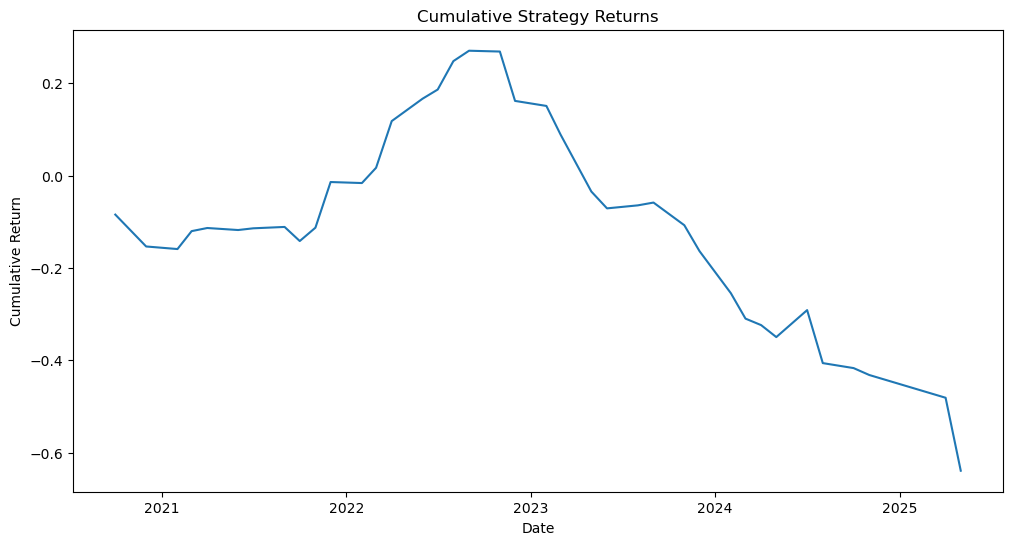

In [37]:
import matplotlib.pyplot as plt
def calculate_monthly_strategy_returns():
    """
    Calculate monthly returns: Long basket return - Short basket return
    """
    strategy_returns = pd.Series(index=monthly_dates)
    
    for i in range(len(monthly_dates)-1):
        current_month = monthly_dates[i]
        next_month = monthly_dates[i+1]
        
        # Get the positions from current rebalancing
        positions = portfolio_positions[current_month]
        long_tickers = list(positions['long_positions'].keys())
        short_tickers = list(positions['short_positions'].keys())
        
        # Calculate monthly returns for each basket
        long_basket_return = 0
        short_basket_return = 0
        
        # Long basket return (equal weighted)
        for ticker in long_tickers:
            if ticker in price_data.index:
                start_price = price_data.loc[ticker, current_month]
                end_price = price_data.loc[ticker, next_month]
                monthly_return = (end_price / start_price) - 1
                long_basket_return += monthly_return
        
        long_basket_return /= len(long_tickers)  # Equal weight average
        
        # Short basket return (equal weighted)
        for ticker in short_tickers:
            if ticker in price_data.index:
                start_price = price_data.loc[ticker, current_month]
                end_price = price_data.loc[ticker, next_month]
                monthly_return = (end_price / start_price) - 1
                short_basket_return += monthly_return
        
        short_basket_return /= len(short_tickers)  # Equal weight average
        
        # Strategy return = Long return - Short return
        strategy_returns[current_month] = long_basket_return - short_basket_return
    
    return strategy_returns.dropna()

# Calculate strategy returns
strategy_returns = calculate_monthly_strategy_returns()

# Calculate performance metrics (their exact formulas)
total_return = strategy_returns.sum()
ann_return = 100*((1 + total_return)**(12.0 /float(strategy_returns.index.size))-1)

print('=== STRATEGY PERFORMANCE ===')
print(f'Total Return: {total_return:.4f}')
print(f'Annual Returns: {ann_return:.2f}%')
print(f'Number of months: {len(strategy_returns)}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(strategy_returns.index, strategy_returns.cumsum())
plt.title('Cumulative Strategy Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.show()

In [38]:
# Let's examine what happened with the correlations and rankings
print("=== RANKING DEBUG ===")
print("\nTop 10 stocks (highest momentum correlation - Q5 Long basket):")
top_10 = scores_df_sorted.head(10)
print(top_10[['ticker', 'spearman_corr']])

print("\nBottom 10 stocks (lowest momentum correlation - Q1 Short basket):")
bottom_10 = scores_df_sorted.tail(10)
print(bottom_10[['ticker', 'spearman_corr']])

print("\nTech stocks correlation scores:")
tech_stocks = ['NVDA', 'META', 'GOOGL', 'AMD', 'MSFT', 'APP', 'CRM']
for stock in tech_stocks:
    if stock in scores_df['ticker'].values:
        corr = scores_df[scores_df['ticker'] == stock]['spearman_corr'].iloc[0]
        print(f"{stock}: {corr:.3f}")

=== RANKING DEBUG ===

Top 10 stocks (highest momentum correlation - Q5 Long basket):
   ticker  spearman_corr
32     PG       0.379251
0     LIN       0.373510
31   COST       0.342570
53     MA       0.315524
44    EPD       0.302726
52      V       0.282010
75    HON       0.279842
80   WELL       0.279332
30    WMT       0.267592
77    UNP       0.252157

Bottom 10 stocks (lowest momentum correlation - Q1 Short basket):
   ticker  spearman_corr
95   PLTR      -0.041787
79    LMT      -0.046975
3     NEM      -0.055691
72    CAT      -0.058090
70     GE      -0.060143
10   GOOG      -0.069466
98    CRM      -0.130591
17   SPOT      -0.155624
11   META      -0.222517
18    APP      -0.271867

Tech stocks correlation scores:
NVDA: -0.029
META: -0.223
AMD: -0.040
MSFT: 0.007
APP: -0.272
CRM: -0.131


In [39]:
# Debug APP's momentum specifically
print("=== APP MOMENTUM DEBUG ===")

# Check APP's actual price trend
app_prices = price_data.loc['APP'].tail(100)  # Last 100 days
print(f"APP price 100 days ago: ${app_prices.iloc[0]:.2f}")
print(f"APP price today: ${app_prices.iloc[-1]:.2f}")
print(f"APP total return: {((app_prices.iloc[-1]/app_prices.iloc[0]) - 1)*100:.1f}%")

# Check the momentum calculation
app_momentum = momentum_1m.loc['APP'].dropna()
print(f"\nAPP momentum values (last 10):")
print(app_momentum.tail(10))

# Check forward returns
app_forward_returns = forward_returns_1m.loc['APP'].dropna()
print(f"\nAPP forward returns (last 10):")
print(app_forward_returns.tail(10))

# Manual correlation check
from scipy.stats import spearmanr
common_dates = app_momentum.index.intersection(app_forward_returns.index)
if len(common_dates) > 10:
    manual_corr, p_val = spearmanr(app_momentum[common_dates], app_forward_returns[common_dates])
    print(f"\nManual correlation: {manual_corr:.3f} (p-value: {p_val:.3f})")

=== APP MOMENTUM DEBUG ===
APP price 100 days ago: $346.29
APP price today: $438.68
APP total return: 26.7%

APP momentum values (last 10):
Date
2025-08-04 00:00:00-04:00    0.216538
2025-08-05 00:00:00-04:00    0.126804
2025-08-06 00:00:00-04:00    0.117575
2025-08-07 00:00:00-04:00    0.290850
2025-08-08 00:00:00-04:00    0.312361
2025-08-11 00:00:00-04:00    0.394871
2025-08-12 00:00:00-04:00    0.333981
2025-08-13 00:00:00-04:00    0.325849
2025-08-14 00:00:00-04:00    0.289702
2025-08-15 00:00:00-04:00    0.284042
Name: APP, dtype: float64

APP forward returns (last 10):
Date
2025-06-20 00:00:00-04:00   -0.177995
2025-06-23 00:00:00-04:00   -0.112534
2025-06-24 00:00:00-04:00   -0.105205
2025-06-25 00:00:00-04:00   -0.225317
2025-06-26 00:00:00-04:00   -0.238015
2025-06-27 00:00:00-04:00   -0.283088
2025-06-30 00:00:00-04:00   -0.250364
2025-07-01 00:00:00-04:00   -0.245766
2025-07-02 00:00:00-04:00   -0.224627
2025-07-03 00:00:00-04:00   -0.221209
Name: APP, dtype: float64

Manua

In [35]:
#Goal is to create a database with the tickers as indexes and the dates as columns -> transpose and rename
# fetch data per ticker from yfinanec and merge
#How to transpose and add row?
#Calculate momentum
# 
